# Проверка гипотез для увеличения выручки интернет-магазина

<b> Описание проекта:</b>

В нашем распоряжении список гипотез для увеличения выручки. Hам нужно приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

У нас есть:

файл hypothesis.csv (/datasets/hypothesis.csv) - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

файлы orders.csv и visitors.csv  (/datasets/orders.csv,  /datasets/visitors.csv) с описанием результатов  A/B-теста

<b> Цель исследования:</b>

Выяснить -какая из гипотез приведет к наибольшему увеличению выручки.


Проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки поищем возможность исправить самые критичные ошибки данных.

<b>Разделим проект на несколько шагов:</b>

- Предобработка данных;

- Приоритизация гипотез;

- Анализ A/B-теста;

- Принятие решения по результатам теста.

## Загрузка данных и подготовка их к анализу

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import scipy.stats as stats
import datetime as dt

#столбцы и строки полностью, формат округлен
pd.set_option('display.max_columns', None)
#pd.options.display.float_format = '{:,.2f}'.format
#вывод значений без сокращений
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_48/3806187664.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Предобработка таблицы hypothesis - гипотезы

In [3]:
# напишем функцию для  вывода состава столбцов
def data_review(data):
    display(data.head())
    print('-----------------------------------------------------------')
    print(data.info())
    print('-----------------------------------------------------------')
    print(data.describe())
    print('-----------------------------------------------------------')
    print(data.isna().sum())
    print('-----------------------------------------------------------')
    print(data.duplicated().sum())

In [4]:
data_review(hypothesis)


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
-----------------------------------------------------------
           Reach     Impact  Confidence    Efforts
count  9.000000   9.000000   9.000000    9.000000 
mean   4.777778   4.777778   5.555556    4.888889 
std    3.153481   3.192874   3.045944    2.803767 
min    1.000000   1.000000   1.000000    1.000000 
25%    3.000000   3.000000   3.000000    3.000000 
50%    3.000000   3.000000   7.000000    5.000000 
75%    8.000000   7.000000   8.000000    6.000000 
max    10.000000  10.000000  9.0

*С данными все в порядке, типы правильные, дубликатов нет - таблица готова к анализу.*


### Предобработка таблицы orders - заказы

In [5]:
data_review(orders)


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
-----------------------------------------------------------
       transactionId     visitorId       revenue
count  1.197000e+03   1.197000e+03  1.197000e+03
mean   2.155621e+09   2.165960e+09  8.348006e+03
std    1.229085e+09   1.236014e+09  3.919113e+04
min    1.062393e+06   5.114589e+06  5.000000e+01
25%    1.166776e+09   1.111826e+09  1.220000e+03
50%    2.145194e+09   2.217985e+09  2.978000e+03
75%    3.237740e+09   3.177606e+09  8.290000e+03
max    4.293856e+09   4.2

In [6]:
# Tип столбца "date" поменяем на datetime

orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


*С данными все в порядке, типы правильные, дубликатов нет - таблица готова к анализу.
Поменяли только тип столбца "date" на datetime.*


### Предобработка таблицы visitors - посетители

In [7]:
data_review(visitors)


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
-----------------------------------------------------------
         visitors
count  62.000000 
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000
-----------------------------------------------------------
date        0
group       0
visitors    0
dtype: int64
-----------------------------------------------------------
0


In [8]:
# Поменяем тип столбца "visitors" на datetime
visitors['date'] = pd.to_datetime(visitors['date'])


In [9]:
visitors["date"].describe()


/tmp/ipykernel_48/1137561735.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  visitors["date"].describe()


count     62                 
unique    31                 
top       2019-08-27 00:00:00
freq      2                  
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [10]:
# создадим список с датасетами
all_data = [hypothesis, orders, visitors]

# Приведем названия столбцов к нижнему регистру и заменим пробелы нижним подчеркиванием
for data in all_data:
    data.columns = [x.lower().replace(' ', '_') for x in data.columns.values]

In [11]:
orders = orders.rename(columns={'transactionid': 'transaction_id', 'visitorid': 'visitor_id'}) 


In [12]:
# выведем 5 случайных строк
display(hypothesis.sample(5))
display(orders.sample(5))
display(visitors.sample(5))


,hypothesis,reach,impact,confidence,efforts
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transaction_id,visitor_id,date,revenue,group
319,2414788465,2247745159,2019-08-19,1435,B
1188,1692103379,1022829655,2019-08-14,112,A
1046,3533389249,410113592,2019-08-11,1799,B
1019,453824282,4256040402,2019-08-31,1850,B
961,401622769,635956745,2019-08-10,11250,A


,date,group,visitors
29,2019-08-30,A,490
31,2019-08-01,B,713
37,2019-08-07,B,709
1,2019-08-02,A,619
44,2019-08-14,B,746


Вывод: Hазвания столбцов поменяли и привели их к нижнему регистру. Изменили типы данныx в столбцах, содержащих информацию о дате и времени.*

## Приоритизация гипотез

Для принятия решения о приоритетной для анализа гипотезе применим фреймворки ICE и RICE. Отсортируем их по убыванию приоритета.

In [13]:
# создаем новый столбец ice и отсортируем по убыванию приоритета
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'], 3)
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))


,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


In [14]:
# создаем новый столбец rice и отсортируем по убыванию приоритета
hypothesis['rice'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'], 3)
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


*Hаиболее приоритетные гипотезы по ICE:*

8-  Запустить акцию, дающую скидку на товар в день рождения

0-  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

7-  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

*Hаиболее приоритетные гипотезы по RICE:*

7- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2-Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

0- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Здесь мы можем наглядно yвидеть разницу в результатах таблиц, первая тройка меняется cлeдующим образом: в ICE это гипотезы под номерами 8, 0, 7 , то в RICE - 7(была на 3 меcте), 2(былa на 5), 0(была на 2). Это отличие возникает из-за параметра Reach в RICE. Поэтому предложим для тестирования:


7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

2 - Добавить блоки рекомендации товаров на сайт интернет магазина;

0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.



## Анализ A/B-теста

* Построим график кумулятивной выручки по группам. Сделаем выводы и предположения;
* Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения;
* Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения;
* Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения;
* Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения;
* Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения;
* Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей;
* Построим точечный график стоимостей заказов. Сделаем выводы и предположения;
* Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов;
* Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения;
* Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения;
* Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения;
* Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения;

Примем решение по результатам теста и объясним его. Варианты решений теста:

1. Остановить тест, зафиксировать победу одной из групп.


2. Остановить тест, зафиксировать отсутствие различий между группами.


3. Продолжить тест.

Перед началом работы проверим наличие пользователей, попавших в обе группы:


In [15]:
# Проверим пользователей попавших в обе выборки
group_A = orders[orders['group'] == 'A']['visitor_id']
group_B = orders[orders['group'] == 'B']['visitor_id']
users_duplicated = orders.query('visitor_id in @group_A and visitor_id in @group_B')
display(users_duplicated['visitor_id'].unique())

print('Общее количество пользователей в двух группах',  users_duplicated['visitor_id'].nunique())
print('Общее количество пользователей               ',  orders['visitor_id'].nunique())

array([4069496402,  963407295,  351125977, 3234906277,  199603092,
        237748145, 3803269165, 2038680547, 2378935119, 4256040402,
       2712142231,    8300375,  276558944,  457167155, 3062433592,
       1738359350, 2458001652, 2716752286, 3891541246, 1648269707,
       3656415546, 2686716486, 2954449915, 2927087541, 2579882178,
       3957174400, 2780786433, 3984495233,  818047933, 1668030113,
       3717692402, 2044997962, 1959144690, 1294878855, 1404934699,
       2587333274, 3202540741, 1333886533, 2600415354, 3951559397,
        393266494, 3972127743, 4120364173, 4266935830, 1230306981,
       1614305549,  477780734, 1602967004, 1801183820, 4186807279,
       3766097110, 3941795274,  471551937, 1316129916,  232979603,
       2654030115, 3963646447, 2949041841])

Общее количество пользователей в двух группах 58
Общее количество пользователей                1031


Oколо 5.6 % (58) пользователей от общего числа(1031). Поскольку их присутствие может исказить результаты теста
было принято решение удалить этих пользователей.

In [16]:

orders = orders.query('visitor_id not in @users_duplicated["visitor_id"]')
print('Всего пользователей в тесте осталось:', orders['visitor_id'].nunique())


Всего пользователей в тесте осталось: 973


### График  кумулятивной выручки по группам

In [17]:
orders.sample(3)


,transaction_id,visitor_id,date,revenue,group
1191,3592955527,608641596,2019-08-14,16490,B
213,394880746,3332057097,2019-08-02,2750,B
378,1964998089,2618159035,2019-08-25,5415,A


In [18]:
# Рассчитаем медианную выручку за день в каждой группе

orders.groupby(['date','group'])['revenue'].sum().groupby('group').median()


group
A    92365 
B    107340
Name: revenue, dtype: int64

In [19]:
visitors.sample(3)


,date,group,visitors
20,2019-08-21,A,646
38,2019-08-08,B,654
18,2019-08-19,A,502


In [20]:
# Сравним идентичны ли даты и группы в таблицах заказов и посетителей, что бы в дальнейшем объединить данные

orders[['date','group']].drop_duplicates().sort_values(by=['date','group']).reset_index(drop=True)



,date,group
0,2019-08-01,A
1,2019-08-01,B
2,2019-08-02,A
3,2019-08-02,B
4,2019-08-03,A
...,...,...
57,2019-08-29,B
58,2019-08-30,A
59,2019-08-30,B
60,2019-08-31,A


In [21]:
similarity = orders[['date','group']].drop_duplicates().sort_values(by=['date','group']).reset_index(drop=True) == \
                        visitors[['date','group']].drop_duplicates().sort_values(by=['date','group']).reset_index(drop=True)
similarity

,date,group
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
57,True,True
58,True,True
59,True,True
60,True,True


In [22]:
similarity['date'].sum() , similarity['group'].sum()


(62, 62)

*Все пары дата-группа в таблицах посетители и заказы совпадают, можно объединять*

Создадим таблицу cumulativeData куммулятивных данных по обеим таблицам



In [23]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]. \
                                     agg({'date' : 'max', 
                                          'group' : 'max', 
                                          'transaction_id' : pd.Series.nunique, 
                                          'visitor_id' : pd.Series.nunique, 
                                          'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]. \
                                       agg({'date' : 'max', 
                                            'group' : 'max', 
                                            'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


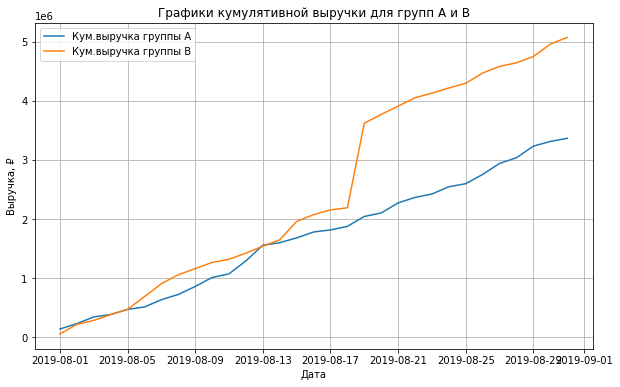

In [24]:
# построим графики кумулятивной выручки для обоих групп

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


plt.figure(figsize=(10,6))
plt.title('Графики кумулятивной выручки для групп A и B', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Выручка, ₽', fontsize=10)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Кум.выручка группы A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Кум.выручка группы B')
plt.grid()
plt.legend()
plt.show()

*Вывод: Выручка практически равномерно растёт в обеих группах за период теста. Начиная со второй половины месяца выручка в группе B растет быстрее. Стоит отметить  всплеск выручки в группе B 19-08-2019. Это может говорить о увелечении числа заказов  или о наличии дорогих заказов в этот день*



### График кумулятивного среднего чека по группам.

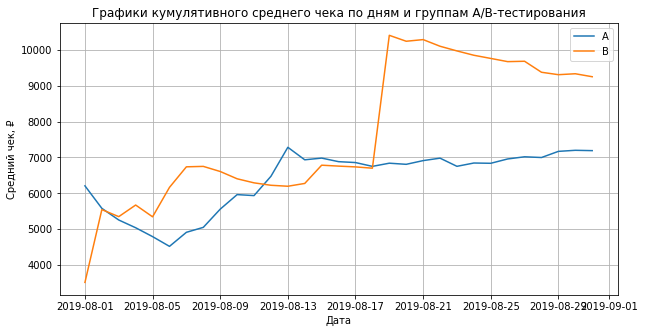

In [25]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.grid(visible=True)
plt.title('Графики кумулятивного среднего чека по дням и группам A/B-тестирования', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Средний чек, ₽', fontsize=10)
plt.legend() 
plt.show()

*После некоторого снижения в первые числа месяца средний чек в группе А вырoвнялся в пределах зниачения выше 7000 т.рублей с тенденцией в росте. В группе B наблюдается постепенный рост значений среднего чека с максимальным значением 19 августа, вероятнеее всего это влияние одного или нескольких заказов на большую сумму , затем средний чек идет на медленный спад.*

### График относительного изменения кумулятивного среднего чека группы B к группе A

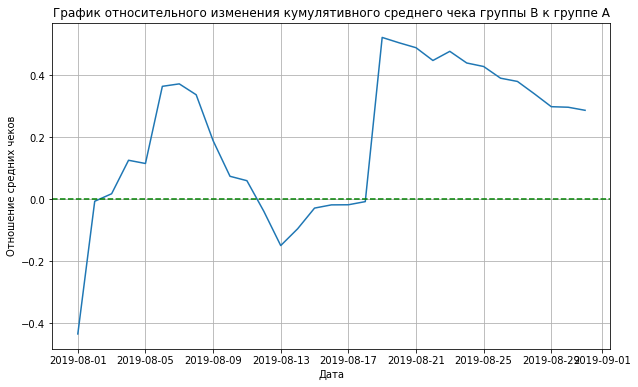

In [26]:
# объеденим все данные в один датафреим

merged_cumulative_revenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])
plt.figure(figsize=(10, 6))

# построим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenueB']/
          merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/
          merged_cumulative_revenue['ordersA'])-1)

# добавим ось X
plt.axhline(y=0, color='green', linestyle='--')

plt.grid(visible=True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Отношение средних чеков', fontsize=10)
plt.show()



*Резкие подъемы говорят о заказах на большую сумму. По сути этот график является отражением графика в пункте 3.2. Здесь, также, наблюдается рост среднего чека до 8 августа, затем спад среднего чека ниже среднего чека группы А до 15 августа, скачок 19 числа, и вновь постепенное снижение.*







### График кумулятивной конверсии по группам

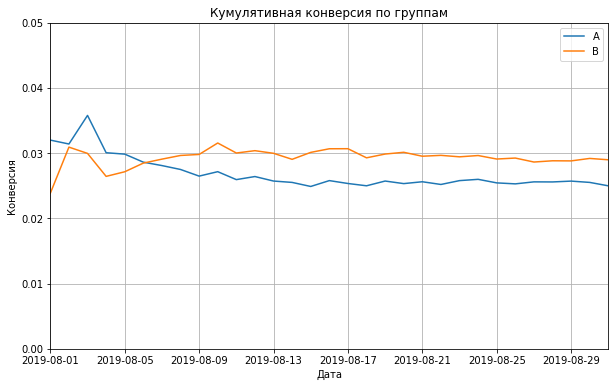

In [27]:

register_matplotlib_converters()

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10, 6))

# построим графики и зададим масштаб осей

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05]) 

plt.grid(visible=True)
plt.title('Кумулятивная конверсия по группам', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Конверсия', fontsize=10)
plt.legend()
plt.show()

  
*В начале месяца наблюдается неустойчивость значения конверсии, но после 4 числа конверсия группы А зафиксировалась на уровне ниже значений начала месяца, в то время как конверсия группы B начала расти и остановилась на уровне больше группы А.*




### График относительного изменения кумулятивной конверсии группы B к группе A

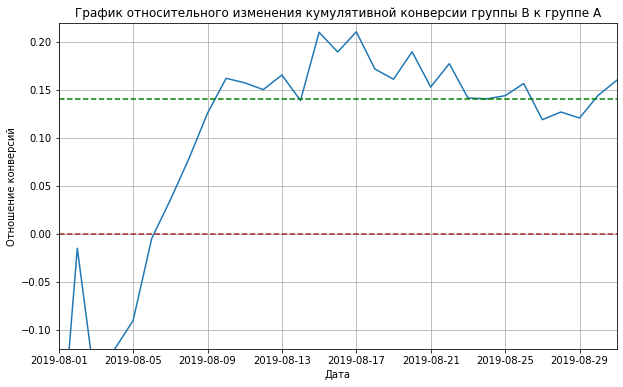

In [28]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])

plt.figure(figsize=(10,6))

# cтроим отношение конверсий
plt.plot(merged_cumulative_conversions['date'],
         merged_cumulative_conversions['conversionB']/
         merged_cumulative_conversions['conversionA']-1)

# добавляем оси X
plt.axhline(y=0, color='brown', linestyle='--')
plt.axhline(y=0.14, color='green', linestyle='--')


plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.12, 0.22])

plt.grid(visible=True)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Отношение конверсий', fontsize=10)
plt.show()

Вывод: В начале теста группа B показывала нижние границы значений по отношению к группе А, но затем все меняется в обратную сторону и конверсия группы B остановилaсь на уровне 12-14 %.


### График количества заказов по пользователям

In [29]:
orders.sample(3)


,transaction_id,visitor_id,date,revenue,group
818,3069553209,1351898488,2019-08-21,4600,A
862,4203085435,980818195,2019-08-30,7110,A
531,4016435970,4017075195,2019-08-19,13390,A


In [30]:
# число заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .sort_values(by='transaction_id', ascending=False)
    .rename(columns={'transaction_id': 'orders'})
)

display(orders_by_users.head(10))

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Можно заметить нескольких пользователей с большим количеством заказов.



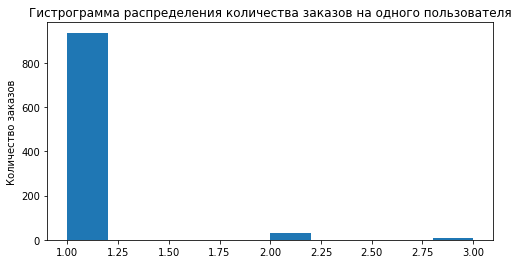

In [31]:
# построим гистограмму распределения количества заказов на одного пользователя

plt.figure(figsize=(8, 4))
plt.hist(orders_by_users['orders']) 
plt.title('Гистрограмма распределения количества заказов на одного пользователя', fontsize=12)
plt.ylabel('Количество заказов', fontsize=10)
plt.show()


*Большая часть пользователей остановилась на одном заказе. Хотя есть и пользователи, которые сделали 10 заказов*.



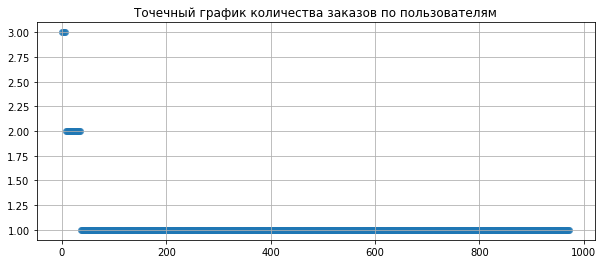

In [32]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(10,4))
plt.grid()
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_values, orders_by_users['orders'], alpha=0.4) ;

*Большая часть пользователей совершили 1 заказ. Тех, кто совершили 2 заказа намного меньше. Непонятно брать ли за аномалии заказы 3 и более раза, поэтому посчитаем процентили (95 и 99). *





### Граница для определения аномальных пользователей

In [33]:
print('95 и 99 перцентили по заказам: ', np.percentile(orders_by_users['orders'], [95, 99])) 


95 и 99 перцентили по заказам:  [1. 2.]


*Не более 5%  пользователей совершали больше 2-х заказов и меньше 1% пользоваетелей совершали больше 2-х заказов. Поэтому возьмем 4 заказа на одного пользователя как нижнюю границу, все остальные будем считать аномалиями.*
 

Для большей точности рассчитаем все процентили с 95 по 99



In [34]:
print('перцентили c 95 по 99 по заказам: ', np.percentile(orders_by_users['orders'], [95,96,97,98, 99])) 


перцентили c 95 по 99 по заказам:  [1. 1. 2. 2. 2.]


*98% пользователей делают 1 или 2 заказа. Все остальное- аномалия.*



### Tочечный график стоимостей заказов

In [35]:
# топ-5 самых дорогих по стоимости заказов 
display(orders.sort_values(by='revenue', ascending=False).head())

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A


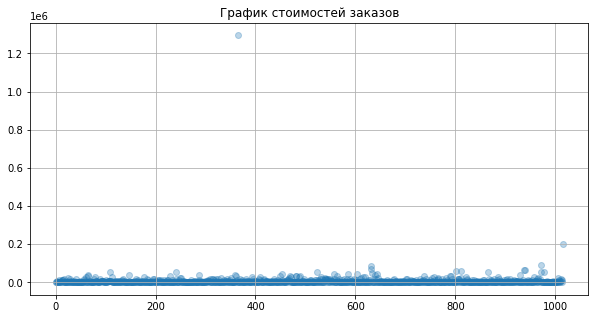

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.grid()
plt.title('График стоимостей заказов')
plt.scatter(x_values, orders['revenue'], alpha=0.3);

Изменим масштаб и отбросим выбросы с revenue больше 200 000:


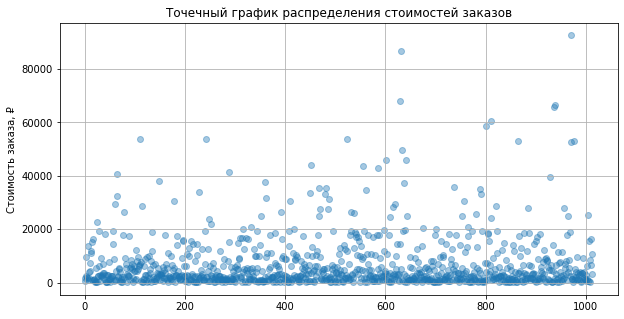

In [37]:
norm_orders = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(norm_orders)))
plt.figure(figsize=(10, 5))
plt.grid()
plt.title('Точечный график распределения стоимостей заказов', fontsize=12)
plt.ylabel('Стоимость заказа, ₽', fontsize=10)
plt.scatter(xn_values, norm_orders, alpha=0.4);



*По графику можно заметить несколько крупных заказов. За границу аномальных значении можно выбрать диапазон заказов от 25 000 и 75 000 руб. Так как точное количество таких заказов неизвестно — считать их аномалиями или нет мы пока не можем.*

### Граница для определения аномальных заказов (по выручке)

In [38]:
# Методом np.percentile('column', [percentile1, percentile2, percentile3]) находим перцентили
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


*Mеньше 5% заказов имеют cтоимость от 26785 руб и более, не более 1%- стоимость заказа  от 53904 руб. За нижнюю границу можно выбрать стоимость заказа в 26785 и отсеять аномальные заказы по этой границе.*


### Статистическая значимость различий в среднем количестве заказов на пользователя между группами по «сырым» данным

*Сформулируем гипотезы:*

*H₀* - различий в среднем количестве заказов на пользователя между группами A и B нет,


*H₁* - различия в среднем количестве заказов на пользователя между группами A и B есть.

Для расчета статистической значимости различий в конверсии между группами нам необходимо подготовить имеющиеся данные. Создадим новый датафрейм data со следующими столбцами:

-  *date* - дата;
-  *orders_a_daily* - количество заказов в выбранную дату в группе A;
-  *revenue_per_date_a* - суммарная выручка в выбранную дату в группе A;
-  *orders_b_daily* - количество заказов в выбранную дату в группе B;
-  *revenue_per_date_b* - суммарная выручка в выбранную дату в группе B;
-  *orders_a_cummulative* - суммарное число заказов до выбранной даты включительно в группе A;
-  *revenue_cummulative_a* - суммарная выручка до выбранной даты включительно в группе A;
-  *orders_b_cummulative* - суммарное число заказов до выбранной даты включительно в группе B;
-  *revenue_cummulative_b* - суммарная выручка до выбранной даты включительно в группе B;
-  *visitors_a_daily* - количество пользователей в выбранную дату в группе A;
-  *visitors_a_cummulative* - количество пользователей до выбранной даты включительно в группе A;
-  *visitors_b_daily* - количество пользователей в выбранную дату в группе B;
-  *visitors_b_cummulative* - количество пользователей до выбранной даты включительно в группе B.




In [39]:
# расчет количества пользователей в выбранную дату в группе А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# расчет количества пользователей до выбранной даты включительно в группе А
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# расчет количества пользователей в выбранную дату в группе В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# расчет количества пользователей до выбранной даты включительно в группе В
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

# расчет количества заказов и суммарной выручки в выбранную дату в группе A
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']


# расчет суммарного числа заказов до выбранной даты включительно в группе A
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

# расчет количества заказов и суммарной выручки в выбранную дату в группе В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# расчет суммарного числа заказов до выбранной даты включительно в группе В
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]


In [40]:
# объединение датафреймов в один общий
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


1. Создадим переменные orders_by_users_a и orders_by_users_b со столбцами ['visitor_id', 'orders'], для пользователей которые заказывали минимум 1 раз, укажем количество заказов.

2. Объявим переменные sample_a и sample_b, в которых пользователям с заказами будет соответствовать количество заказов пользователя, а пользователям без заказов — нули.

3. Посчитаем статистическую значимость различия конверсии по результатам месяца теста.

4. Применим тест Манна-Уитни.

5. Выведем p-value для сравнения конверсии между группами.

6. Вычислим относительное различие в конверсии между группами.

In [41]:
# создадим датафреймы, в которых указано число заказов для пользователей, которые заказывали минимум 1 раз
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

# переменныe в которых пользователям с заказами будет соответствовать число заказов пользователя,
# пользователям без заказов — нули
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(0, index=np.arange(
                          data['visitors_per_date_a'].sum() -
                          len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(
                          data['visitors_per_date_b'].sum() -
                          len(orders_by_users_b['orders'])), name='orders')], axis=0)

# рассчет статистической значимости различия конверсии по результатам теста Манна-Уитни
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

# рассчет относительного различия в конверсии между группами
print('Относительное различие в средней конверсии между группами по «сырым» данным:',
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

p-value = 0.011
Относительное различие в средней конверсии между группами по «сырым» данным: 0.160


* p-value = 0.017, что меньше 0.05. Значит нулевую гипотезу об отсутствии различий в конверсии между группами можно отвергнуть. Средняя конверсия группы В больше средней конверсии группы А. Это означает что есть различия по «сырым» данным в конверсии групп A и B.*


### Статистическая значимость различий в  среднем количестве заказов на пользователя между группами по «очищенным» данным

Прежде было замечено, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рублям, a 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказам на пользователя. За аномальных пользователей будем считать тех кто совершил 2 и более заказа или совершил заказ дороже 28 000 рублей и сохраним это как multiple_orders и pricy. Тем самым мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 2 — multiple_orders_users и пользователей, совершивших заказы дороже 28 000 — users_pricy. Объединим их в таблице anormal, в конце посчитаем количество аномальных пользователей методом shape().

In [42]:
multiple_orders = np.percentile(orders_by_users['orders'], 95)
pricy = np.percentile(orders['revenue'], 95)
multiple_orders_users = pd.concat([
    orders_by_users_a[orders_by_users_a['orders'] > multiple_orders]['visitor_id'],
    orders_by_users_b[orders_by_users_b['orders'] > multiple_orders]['visitor_id']], axis=0)
users_pricy = orders[orders['revenue'] > pricy]['visitor_id']
anormal = (pd.concat([
    multiple_orders_users,
    users_pricy], axis=0)
                  .drop_duplicates()
                  .sort_values())

print(anormal .head())
print('\n')
print('Количество аномальных пользователей:', anormal.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64


Количество аномальных пользователей: 86


 1. *Выясним влияние аномальных пользователей(74) на результаты теста.*

 2. *Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным.*
  
 3. *Подготовим выборки количества заказов по пользователям по группам теста и применим критерий Манна-Уитни к полученным выборкам.*

Гипотезы:

H₀ - различий в конверсии между группами нет;

H₁ - различия в конверсии между группами есть.

In [43]:
sample_a_filtered = pd.concat([
    orders_by_users_a[np.logical_not(
        orders_by_users_a['visitor_id']
        .isin(anormal))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() -
                                 len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b_filtered = pd.concat([
    orders_by_users_b[np.logical_not(
        orders_by_users_b['visitor_id']
        .isin(anormal))]['orders'],
    pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() -
                                 len(orders_by_users_b['orders'])), name='orders')], axis=0)

# рассчет статистической значимости различия конверсии по результатам теста Манна-Уитни
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

# рассчет относительного различия в конверсии между группами
print('Относительное различие в средней конверсии между группами по «очищенным» данным:',
      '{0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

p-value = 0.016
Относительное различие в средней конверсии между группами по «очищенным» данным: 0.174


*p-value = 0.013, меньше 0.05. Это означает, что нулевую гипотезу об отсутствии различий по «очищенным» данным в конверсии между группами отвергаем. По «сырым» данным p-value был равен 0.017. Средняя конверсия группы A меньше средней конверсии группы B. Относительное различие в конверсии между группами по «сырым» данным было равно 0.138. Результаты по «очищенным» данным незначительно отличаются от результатов по «сырым» данным.*

###  Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 






Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:

H₀ - различий в среднем чеке между группами нет; 

H₁ - различия в среднем чеке между группами есть.

 
Передадим критерию mannwhitneyu() данные о выручке с заказов и найдём относительные различия в среднем чеке между группами.

In [44]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
    print("Относительный прирост группы В к группe А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [45]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


P-value: 0.829
Не получилось отвергнуть нулевую гипотезу
Относительный прирост группы В к группe А: 28.660%


*Вывод: P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Cредний чек группы B значительно выше среднего чека группы A.*

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:

H₀ - различий в среднем чеке между группами нет; 

H₁ - различия в среднем чеке между группами есть.

Передадим критерию mannwhitneyu() данные о выручке с заказов без учета аномальных пользователей и найдём относительные различия в среднем чеке между группами.

In [46]:
print('p-value =',
      '{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id']
                       .isin(anormal)))]['revenue'], 
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id']
                       .isin(anormal)))]['revenue'])[1]))

print('Относительное различие в среднем чеке между группами по «очищенным» данным:',
      '{0:.3f}'.format(
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id']
                       .isin(anormal)))]['revenue'].mean() /
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id']
                       .isin(anormal)))]['revenue'].mean() - 1))

p-value = 0.727
Относительное различие в среднем чеке между группами по «очищенным» данным: -0.034


*Вывод: p-value 0.738, что больше 0.05. Это означает, что причин отвергать нулевую гипотезу и считать, что в среднем чеке по «очищенным» данным есть различия, нет.*

## Общий вывод

*Задачей исследования было:*

1. выполнить предобработку данных
2. приоритизировать гипотезы,
3. произвести A/B-тест,
4. проанализировать результаты.

*В первой части было сделано:*

1. Названия столбцов были заменены и приведены к нижнему регистру;
2. Тип данных столбцов изменен там, где это было необходимо

*В ходе приоритизирования гипотез по фреймворкам ICE и RICE удалось определить наиболее важные из них:*

7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

2 - Добавить блоки рекомендации товаров на сайт интернет магазина;

0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.


*В ходе тестирования выяснили:*

- Кумулятивный средний чек группы В выше среднего чека группы А;

- Кумулятивная конверсия группы В выше конверсии группы А;

- Менее 5% от всех пользователей оформляли заказ больше чем 2 раза, 1% пользователей оформляли заказ более 4 раз;

- Менее 5% от всех заказов имеют стоимость больше чем 28 000 рублей, 1% заказов - более 58 233 рублей;

- Относительное различие в средней конверсии между группами: 0.138 по «сырым» данным и 0.173 по «oчищенным»;

-  Гипотеза о равенстве конверсии между группами отвергнута, а относительная разница конверсии группы В на 13.8% больше, чем в группе А. При тестировании "очищенных" от выбросов данных результат также подтвердился: конверсия отличается, а относительная разница составила 18.5%- на столько конверсия группы В больше конверсии группы А;

- Гипотеза о том, что различий в сумме среднего чека между группами нет, не отвергнута с очень большой долей вероятности, а относительная разница суммы среднего чека между группами составила 2.1% (против 25.8% по "сырым" данным)- после удаления выбросов разница между чеками обоих групп стремится к нулю.

*Если основными целями тестрования были определить:*
 
-суммy среднего чека, то она осталась прежней, присутствуют небольшие изменения. 

-получение дополнительной прибыли -тестирование показывает, что конверсия группы В отличается от группы А на 13-18.5%.

*Рекомендации:*

Тест остановить, зафиксировать отсутствие различий между группами по сумме среднего чека и победу группы В в части повышенной конверсии.


